http://archive.ics.uci.edu/dataset/94/spambase

In [1]:
pip install ucimlrepo

You should consider upgrading via the '/Users/johncruz/Documents/GitHub/Social-Network-Analysis/chapter2/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from nltk.classify import NaiveBayesClassifier
from nltk.classify.util import accuracy as nltk_accuracy
import nltk

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
spambase = fetch_ucirepo(id=94) 
  
# data (as pandas dataframes) 
X = spambase.data.features 
y = spambase.data.targets 


# Split dataset
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=500, stratify=y, random_state=42)
X_train, X_devtest, y_train, y_devtest = train_test_split(X_temp, y_temp, test_size=500, stratify=y_temp, random_state=42)

# Feature Selection
selector = SelectKBest(mutual_info_classif, k=15)
X_train_sel = selector.fit_transform(X_train, y_train)
X_devtest_sel = selector.transform(X_devtest)
X_test_sel = selector.transform(X_test)
top_features = X_train.columns[selector.get_support()].tolist()
print("Top 15 selected features:", top_features)

# --- Scikit Logistic Regression ---
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_sel, y_train)
pred_lr = lr.predict(X_test_sel)
print("\n[Logistic Regression] Accuracy:", accuracy_score(y_test, pred_lr))
print(classification_report(y_test, pred_lr))

# --- Random Forest ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_sel, y_train)
pred_rf = rf.predict(X_test_sel)
print("\n[Random Forest] Accuracy:", accuracy_score(y_test, pred_rf))
print(classification_report(y_test, pred_rf))

# Feature Importance
importances = pd.Series(rf.feature_importances_, index=top_features)
print("\n[Random Forest] Top features by importance:")
print(importances.sort_values(ascending=False))

# --- NLTK Naive Bayes ---
# Convert selected features into dictionaries (format required by NLTK)
def to_nltk_format(X_df):
    return [dict(zip(X_df.columns, row)) for row in X_df.values]

# Get the selected features only
X_train_nltk = X_train[top_features]
X_devtest_nltk = X_devtest[top_features]
X_test_nltk = X_test[top_features]

# Convert to nltk format
train_set = list(zip(to_nltk_format(X_train_nltk), y_train.values.ravel()))
devtest_set = list(zip(to_nltk_format(X_devtest_nltk), y_devtest.values.ravel()))
test_set = list(zip(to_nltk_format(X_test_nltk), y_test.values.ravel()))

# Train the Naive Bayes classifier
nltk_nb = NaiveBayesClassifier.train(train_set)

# Evaluate on test set
print("\n[Naive Bayes - NLTK] Accuracy:", nltk_accuracy(nltk_nb, test_set))

# Classification report for NLTK Naive Bayes
pred_nb = [nltk_nb.classify(fs) for fs, _ in test_set]
print(classification_report(y_test, pred_nb))

# Show the most informative features
nltk_nb.show_most_informative_features(10)

/Users/johncruz/Documents/GitHub/Social-Network-Analysis/chapter2/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Top 15 selected features: ['word_freq_our', 'word_freq_remove', 'word_freq_free', 'word_freq_business', 'word_freq_you', 'word_freq_your', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_george', 'char_freq_!', 'char_freq_$', 'capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total']

[Logistic Regression] Accuracy: 0.912
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       303
           1       0.91      0.86      0.88       197

    accuracy                           0.91       500
   macro avg       0.91      0.90      0.91       500
weighted avg       0.91      0.91      0.91       500



/Users/johncruz/Documents/GitHub/Social-Network-Analysis/chapter2/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/johncruz/Documents/GitHub/Social-Network-Analysis/chapter2/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/johncruz/Documents/GitHub/Social-Network-Analysis/chapter2/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/johncruz/Documents/GitHub/Social-Network-Analysis/chapter2/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_predict


[Random Forest] Accuracy: 0.932
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       303
           1       0.94      0.88      0.91       197

    accuracy                           0.93       500
   macro avg       0.93      0.92      0.93       500
weighted avg       0.93      0.93      0.93       500


[Random Forest] Top features by importance:
char_freq_!                   0.155395
char_freq_$                   0.127511
word_freq_remove              0.103672
word_freq_free                0.088415
word_freq_your                0.083711
capital_run_length_average    0.082801
capital_run_length_longest    0.070179
word_freq_hp                  0.059033
capital_run_length_total      0.055645
word_freq_money               0.038467
word_freq_you                 0.037312
word_freq_our                 0.032642
word_freq_george              0.026135
word_freq_000                 0.024779
word_freq_business            0.014303
dtype: flo

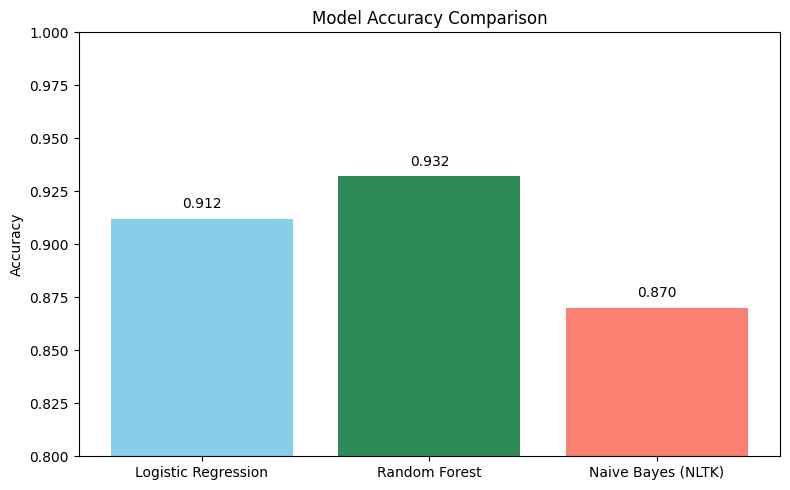

In [18]:
# Collect accuracies
accuracies = {
    "Logistic Regression": accuracy_score(y_test, pred_lr),
    "Random Forest": accuracy_score(y_test, pred_rf),
    "Naive Bayes (NLTK)": nltk_accuracy(nltk_nb, test_set),
}

# Plot
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=['skyblue', 'seagreen', 'salmon'])
plt.ylabel("Accuracy")
plt.ylim(0.8, 1.0)
plt.title("Model Accuracy Comparison")
for i, (name, acc) in enumerate(accuracies.items()):
    plt.text(i, acc + 0.005, f"{acc:.3f}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()
